### 二次元リストから生成

In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

import pandas as pd

# 1 各行を一つのリストとして並べる

list = [
    [1, 100, 0.33, 'AAA', 'AAA100'], 
    [2, 200, 0.67, 'BBB', 'BBB200'], 
    [3, 300, 1, 'CCC', 'CCC300'], 
    [4, 400, 1.33, 'DDD', 'DDD400'], 
    [5, 500, 1.67, 'EEE', 'EEE500'], 
    [6, 600, 2, 'FFF', 'FFF600']
]

# 2 表に変換
# pd.DataFrame(list) : pandasのDataFrameで表に変換
df = pd.DataFrame(list)
# 行名・列名は自動で割り振られた番号になっている

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

df

# 1 各行を一つのリストとして並べる
list = [
[1, 100, 0.33, 'AAA', 'AAA100'], 
[2, 200, 0.67, 'BBB', 'BBB200'], 
[3, 300, 1, 'CCC', 'CCC300'], 
[4, 400, 1.33, 'DDD', 'DDD400'], 
[5, 500, 1.67, 'EEE', 'EEE500'], 
[6, 600, 2, 'FFF', 'FFF600']]


#2 表に変換(オプションで行列名を指定)
ind = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']
col = ['col0', 'col1', 'col2', 'col3', 'col4']

df = pd.DataFrame(list, index=ind, columns=col)


df

# 1 各行を一つのリストにする
list = [
['row0', 1, 100, 0.33, 'AAA', 'AAA100'], 
['row1', 2, 200, 0.67, 'BBB', 'BBB200'], 
['row2', 3, 300, 1, 'CCC', 'CCC300'], 
['row3', 4, 400, 1.33, 'DDD', 'DDD400'], 
['row4', 5, 500, 1.67, 'EEE', 'EEE500'], 
['row5', 6, 600, 2, 'FFF', 'FFF600'], ]

# 2 表に変換
df = pd.DataFrame(list)

# 3 列名を変更
df.columns = ['', 'col0', 'col1', 'col2', 'col3', 'col4']

# 4 行名となる列を指定
df = df.set_index('')

df

# 1 各行ごとのリストを作成

listA = [1, 100, 0.33, 'AAA', 'AAA100']
listB = [2, 200, 0.67, 'BBB', 'BBB200']
listC = [3, 300, 1, 'CCC', 'CCC300']
listD = [4, 400, 1.33, 'DDD', 'DDD400']
listE = [5, 500, 1.67, 'EEE', 'EEE500']
listF = [6, 600, 2, 'FFF', 'FFF600']

# 2 まとめて表に変換

df = pd.DataFrame([listA, listB, listC, listD, listE, listF])

# 3 行名の変更
df.index = ['row0', 'row1', 'row2', 'row3', 'row4', 'row5']

# 4 列名の変更
df.columns = ['col0', 'col1', 'col2', 'col3', 'col4']

del list

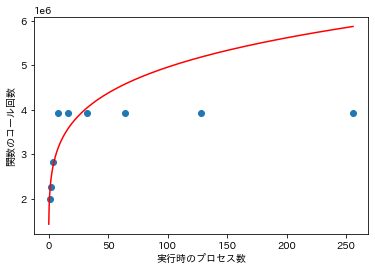

In [2]:
cg_c_data = return_dict_summary_fixed()

x = cg_c_data["processes"]
y = cg_c_data["ICNVRT"]

cg_icnvrt_lr = ModelLog10(x, y, "CG", "ICNVRT")

cg_icnvrt_lr.calc_lr()

cg_icnvrt_lr.plot_graph()

In [3]:
max_in_y = max(y)
# 最大値の個数を取得
y.tolist().count(max_in_y)
# 最大値のインデックスで最小のもの
y.tolist().index(max_in_y)

3

0.0


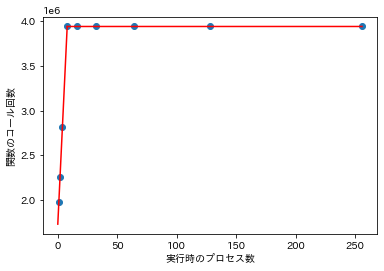

In [4]:
model_branch = ModelBranch(x, y, "CG", "ICNVRT")

model_branch.calc_lr()

model_branch.calc_mape_score()

print(model_branch.mape_score)

model_branch.plot_graph()

In [5]:
# ハセガワ手法でMAPE表を作成するための準備

# ipynb形式のライブラリのインポート
%run ./lib.ipynb

import copy
import itertools

# FT についてやってみる
## FTに適した実行プロセス数を備えたリスト
proceses = processes_excludeBTSP
## FTの辞書を作成
## <関数名>:<実行回数のリスト>, rowData:<実行プロセス数のリスト>
FixedClassList_inFT = return_fixed_class(BenchMark="ft", Processes=processes, FixedBenchMarkClass="C")
FixedClassDataFrame_inFT = pd.concat(FixedClassList_inFT, axis=1)
DictData_inFT = return_dict_Data(FixedClassDataFrame_inFT)
## 実行プロセス数のリストから組み合わせのリストを作成
RowData_inFT = copy.deepcopy(DictData_inFT['rowData'])
RowDataExcludeLargestProcess_inFT = RowData_inFT[:-1]
print(f"RowData_inFT={RowData_inFT}")
print(f"RowDataExcludeLargestProcess_inFT={RowDataExcludeLargestProcess_inFT}")
CombinationProcesses_inFT = list(itertools.combinations(RowDataExcludeLargestProcess_inFT, 3))
print(f"CombinationProcesses_inFT={CombinationProcesses_inFT}")

SET_CLASS_inFT = DictData_inFT['SET_CLASS']
SET_CLASSExcludeDataAtLargestProcess_inFT = SET_CLASS_inFT[:-1]
print(f"SET_CLASSExcludeDataAtLargestProcess_inFT={SET_CLASSExcludeDataAtLargestProcess_inFT}")

CombinationSET_CLASSExcludeDataAtLargestProcess_inFT = list(itertools.combinations(SET_CLASSExcludeDataAtLargestProcess_inFT, 3))
print(f"CombinationSET_CLASSExcludeDataAtLargestProcess_inFT={CombinationSET_CLASSExcludeDataAtLargestProcess_inFT}")

for i in range(len(CombinationSET_CLASSExcludeDataAtLargestProcess_inFT)):
    for j in range(len(CombinationSET_CLASSExcludeDataAtLargestProcess_inFT[i])):
        x_index = np.where(RowDataExcludeLargestProcess_inFT == CombinationProcesses_inFT[i][j])
        y_index = np.where(SET_CLASSExcludeDataAtLargestProcess_inFT==CombinationSET_CLASSExcludeDataAtLargestProcess_inFT[i][j])
        if(x_index != y_index):
            print("E", end=", ")
        else:
            print(f"y_index[{y_index}] == x_index[{x_index}]")

RowData_inFT=[  1   2   4   8  16  32  64 128 256]
RowDataExcludeLargestProcess_inFT=[  1   2   4   8  16  32  64 128]
CombinationProcesses_inFT=[(1, 2, 4), (1, 2, 8), (1, 2, 16), (1, 2, 32), (1, 2, 64), (1, 2, 128), (1, 4, 8), (1, 4, 16), (1, 4, 32), (1, 4, 64), (1, 4, 128), (1, 8, 16), (1, 8, 32), (1, 8, 64), (1, 8, 128), (1, 16, 32), (1, 16, 64), (1, 16, 128), (1, 32, 64), (1, 32, 128), (1, 64, 128), (2, 4, 8), (2, 4, 16), (2, 4, 32), (2, 4, 64), (2, 4, 128), (2, 8, 16), (2, 8, 32), (2, 8, 64), (2, 8, 128), (2, 16, 32), (2, 16, 64), (2, 16, 128), (2, 32, 64), (2, 32, 128), (2, 64, 128), (4, 8, 16), (4, 8, 32), (4, 8, 64), (4, 8, 128), (4, 16, 32), (4, 16, 64), (4, 16, 128), (4, 32, 64), (4, 32, 128), (4, 64, 128), (8, 16, 32), (8, 16, 64), (8, 16, 128), (8, 32, 64), (8, 32, 128), (8, 64, 128), (16, 32, 64), (16, 32, 128), (16, 64, 128), (32, 64, 128)]
SET_CLASSExcludeDataAtLargestProcess_inFT=[1.        0.5       0.25      0.125     0.0625    0.03125   0.015625
 0.0078125]
Combinati

In [6]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

In [7]:
# 変数：test_ratios
# テスト用データとする割合のリスト
test_ratios = [0.3, 0.4, 0.5, 0.6, 0.7]

##### 実行プロセス数のデータをもとにMAPE表を作成する処理 #####

for test_ratio in test_ratios:
    print(f"test_ratio={test_ratio}")
    print(f"train_list, test_list = {split_by_ratio(processes_excludeBTSP, test_ratio)} on processes_excludeBTSP")
    print(f"train_list, test_list = {split_by_ratio(processes_onlyBTSP, test_ratio)} on processes_onlyBTSP")
    print(f"\n")
    fixed_class_list = [0] * len(benchmarks)
    for i in range(len(fixed_class_list)):
        if ( benchmarks[i] == "bt" or benchmarks[i] == "sp" ):
            processes = processes_onlyBTSP
        else:
            processes = processes_excludeBTSP
        fixed_class_list[i] = return_fixed_class(BenchMark = benchmarks[i], Processes = processes, FixedBenchMarkClass = "C")
    fixed_class_DataFrame = [0] * len(fixed_class_list)
    for i in range(len(fixed_class_list)):
        fixed_class_DataFrame[i] = pd.concat(fixed_class_list[i] , axis=1)

    # テーブルの元となるDataFrameを作成する
    MapeTable_source = [0] * len(fixed_class_list)
    for i in range(len(fixed_class_list)):
        dict_data = return_dict_Data(fixed_class_DataFrame[i])
        MapeTable_per_benchmark = return_MapeTable_per_benchmark(dict_data, test_ratio=test_ratio)
        MapeTable_per_benchmark.to_csv(f"./tmp_GenerateResources/{benchmarks[i]}_FixedClass_{test_ratio}.csv")
        MapeTable_row = return_MapeTable_row(MapeTable_per_benchmark, benchmarks[i])
        MapeTable_source[i] = MapeTable_row
    # テーブルの元となるDataFrameにつける列名のリスト
    MapeTable_source_column_name = ["線形モデル", "対数モデル", "反比例モデル", "分岐モデル", "ベンチマーク名"]
    MapeTable = pd.DataFrame(MapeTable_source)
    MapeTable.columns = MapeTable_source_column_name
    MapeTable = MapeTable.set_index('ベンチマーク名')
    # テーブルを欲しい形でCSVとして出力する
    save_MapeTable(MapeTable, suffix=f"FixedClass{test_ratio}")


test_ratio=0.3
train_list, test_list = ([1, 2, 4, 8, 16, 32, 64], [128, 256]) on processes_excludeBTSP
train_list, test_list = ([1, 4, 9, 16, 25, 36, 49, 64, 81, 100], [121, 169, 196, 225]) on processes_onlyBTSP


test_ratio=0.4
train_list, test_list = ([1, 2, 4, 8, 16, 32], [64, 128, 256]) on processes_excludeBTSP
train_list, test_list = ([1, 4, 9, 16, 25, 36, 49, 64, 81], [100, 121, 169, 196, 225]) on processes_onlyBTSP


test_ratio=0.5
train_list, test_list = ([1, 2, 4, 8, 16], [32, 64, 128, 256]) on processes_excludeBTSP
train_list, test_list = ([1, 4, 9, 16, 25, 36, 49], [64, 81, 100, 121, 169, 196, 225]) on processes_onlyBTSP


学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) ==  7
len(self.test_x) == 7
len(self.test_y) == 7
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) ==  7
len(self.test_x) == 7
len(self.test_y) == 7
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) 

In [8]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb



In [9]:
BenchmarkClasses = ["A", "B", "C", "D"]
BenchmarkClasses_on_num = [1, 4, 16, 256]
test_ratios = [0.3, 0.5, 0.8]

##### プロセスを固定し、全体のMAPE表を作成する処理 #####

for test_ratio in test_ratios:
    print(f"test_ratio={test_ratio}")
    print(f"train_list, test_list = {split_by_ratio(BenchmarkClasses, test_ratio)} on BenchmarkClasses")
    print(f"train_list, test_list = {split_by_ratio(BenchmarkClasses_on_num, test_ratio)} on BenchmarkClasses_on_num")
    fixed_process_list = [0] * len(benchmarks)
    for i in range(len(benchmarks)):
        fixed_process_list[i] = return_fixed_process(BenchMark=benchmarks[i], BenchMarkClasses=BenchmarkClasses, FixedProcess=32)

    fixed_process_DataFrame = [0] * len(benchmarks)
    for i in range(len(benchmarks)):
        fixed_process_DataFrame[i] = pd.concat(fixed_process_list[i], axis=1)

    # テーブルの元となるDataFrameを作成する
    MapeTable_source = []
    for i in range(len(fixed_process_list)):
        dict_data = return_dict_Data(fixed_process_DataFrame[i])
        dict_data['rowData'] = BenchmarkClasses_on_num

        try:
            MapeTable_per_benchmark = return_MapeTable_per_benchmark(dict_data, test_ratio=test_ratio)
        except:
            print(f"MAPEを算出するのに問題が生じました。@{benchmarks[i]}")
            continue
        
        MapeTable_per_benchmark = return_MapeTable_per_benchmark(dict_data, test_ratio=test_ratio)
        MapeTable_per_benchmark.to_csv(f"./tmp_GenerateResources/{benchmarks[i]}_FixedProcess_{test_ratio}.csv")
        MapeTable_row = return_MapeTable_row(MapeTable_per_benchmark, benchmarks[i])
        MapeTable_source.append(MapeTable_row)
    # テーブルの元となるDataFrameにつける列名のリスト
    MapeTable_source_column_name = ["線形モデル", "対数モデル", "反比例モデル", "分岐モデル", "ベンチマーク名"]
    MapeTable = pd.DataFrame(MapeTable_source)
    MapeTable.columns = MapeTable_source_column_name
    MapeTable = MapeTable.set_index('ベンチマーク名')
    # テーブルを欲しい形でCSVとして出力する
    save_MapeTable(MapeTable, suffix=f"FixedProcess{test_ratio}")



test_ratio=0.3
train_list, test_list = (['A', 'B', 'C'], ['D']) on BenchmarkClasses
train_list, test_list = ([1, 4, 16], [256]) on BenchmarkClasses_on_num
MAPEを算出するのに問題が生じました。@sp
test_ratio=0.5
train_list, test_list = (['A', 'B'], ['C', 'D']) on BenchmarkClasses
train_list, test_list = ([1, 4], [16, 256]) on BenchmarkClasses_on_num
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self

In [10]:
##### 訓練データ由来のMAPE表を作成する #####

# ipynb形式のライブラリのインポート
%run ./lib.ipynb

##### ベンチマーククラスを固定し、訓練データからMAPE表を作成する処理 #####
# 変数：test_ratios
# テスト用データとする割合のリスト
test_ratios = [0.3, 0.4, 0.5, 0.6, 0.7]

GenerateMapeTableFixClass(Benchmarks=benchmarks, TestRatios=test_ratios, FixBenchmarksClass="C")

# ipynb形式のライブラリのインポート
%run ./lib.ipynb

##### 実行プロセスを固定し、訓練データからMAPE表を作成する処理 #####

# 変数：test_ratios
# テスト用データとする割合のリスト
BenchmarkClasses = ["A", "B", "C", "D"]
BenchmarkClasses_on_num = [1, 4, 16, 256]
test_ratios = [0.3, 0.5, 0.8]

GenerateMapeTableFixProcess(Benchmarks=benchmarks, BenchmarkClasses=BenchmarkClasses, BenchmarkClasses_on_num=BenchmarkClasses_on_num, TestRatios=test_ratios, FixProcess=64 )

test_ratio=0.3
train_list, test_list = ([1, 2, 4, 8, 16, 32, 64], [128, 256]) on processes_excludeBTSP
train_list, test_list = ([1, 4, 9, 16, 25, 36, 49, 64, 81, 100], [121, 169, 196, 225]) on processes_onlyBTSP


test_ratio=0.4
train_list, test_list = ([1, 2, 4, 8, 16, 32], [64, 128, 256]) on processes_excludeBTSP
train_list, test_list = ([1, 4, 9, 16, 25, 36, 49, 64, 81], [100, 121, 169, 196, 225]) on processes_onlyBTSP


test_ratio=0.5
train_list, test_list = ([1, 2, 4, 8, 16], [32, 64, 128, 256]) on processes_excludeBTSP
train_list, test_list = ([1, 4, 9, 16, 25, 36, 49], [64, 81, 100, 121, 169, 196, 225]) on processes_onlyBTSP


学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 3
len(self.train_y) ==  3
len(self.test_x) == 3
len(self.test_y) == 3
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 3
len(self.train_y) ==  3
len(self.test_x) == 3
len(self.test_y) == 3
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 3
len(self.train_y) 

In [11]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb
test_ratios = [0.3, 0.4, 0.5, 0.6, 0.7]

In [12]:
##### ベンチマーククラスをCに固定して各関数で最も予測に適したモデルを算出する処理 #####

for benchmark in benchmarks:
    # 変数：ModelsPerBenchmark
    ModelsPerBenchmark = {}
    MapesPerBenchmark = {}
    Predict256 = {}
    ErrorRate = {}
    if(benchmark == "sp"):
        continue
    print(benchmark)
    for test_ratio in test_ratios:
        # 変数：processes
        # ベンチマークの種類によって異なるプロセス数の条件を吸収するためのもので、実行されたプロセス数のリスト
        processes = return_OptimalProcessesList(benchmark)
        
        # 変数：BestModelsDict
        # ベンチマークFTの各関数における最適なモデルが格納されている
        # 辞書の形式は次の通り
        # <関数名>:<自作クラスによる最適モデル>
        try:
            BestModelsDict = generateBestModelDict(TestRatio=test_ratio, BenchmarkName=benchmark, fixed="Class", fix="C", rowData=processes)
        except:
            print(f"辞書の取得に問題が発生しました@{benchmark}")
            continue
        
        for FunctionName in BestModelsDict.keys():
            if ((FunctionName in ModelsPerBenchmark) ==False):
                ModelsPerBenchmark[FunctionName] = []
            ModelsPerBenchmark[FunctionName].append(BestModelsDict[FunctionName])
            if ((FunctionName in MapesPerBenchmark) ==False):
                MapesPerBenchmark[FunctionName] = []    
            MapesPerBenchmark[FunctionName].append(BestModelsDict[FunctionName].mape_score_InTrain)
            if ((FunctionName in Predict256) ==False):
                Predict256[FunctionName] = []
            Predict256[FunctionName].append(return_Predicted(BestModelsDict[FunctionName], 256))
            if ((FunctionName in ErrorRate) ==False):
                ErrorRate[FunctionName] = []
            ErrorRate[FunctionName].append(return_ErrorRate(FunctionName=FunctionName, PredictNum=Predict256[FunctionName][-1], BenchmarkName=benchmark, BenchmarkClass="C", Process=256))
    MapesPerBenchmarkDataFrame = pd.DataFrame(MapesPerBenchmark.values(), index=MapesPerBenchmark.keys())
    ErrorRatePerBenchmarkDataFrame = pd.DataFrame(ErrorRate.values(), index=ErrorRate.keys())
    Predict256DataFrame = pd.DataFrame(Predict256.values(), index=Predict256.keys())
    MapesPerBenchmarkDataFrame.columns = return_StringTrainList(TestRatio=test_ratios, rowData=processes)
    ErrorRatePerBenchmarkDataFrame.columns = return_StringTrainList(TestRatio=test_ratios,rowData=processes)
    Predict256DataFrame.columns = return_StringTrainList(TestRatio=test_ratios, rowData=processes)    
    MapesPerBenchmarkDataFrame.to_csv(f'./tmp_GenerateResources/{benchmark}_FixedClass_MapeTables.csv')
    ErrorRatePerBenchmarkDataFrame.to_csv(f'./tmp_GenerateResources/{benchmark}_FixedClass_ErrorRate.csv')
    Predict256DataFrame.to_csv(f'./tmp_GenerateResources/{benchmark}_FixedClass_Predict256.csv')

bt
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) ==  7
len(self.test_x) == 7
len(self.test_y) == 7
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) ==  7
len(self.test_x) == 7
len(self.test_y) == 7
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) ==  7
len(self.test_x) == 7
len(self.test_y) == 7
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) ==  7
len(self.test_x) == 7
len(self.test_y) == 7
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) ==  7
len(self.test_x) == 7
len(self.test_y) == 7
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) ==  7
len(self.test_x) == 7
len(self.test_y) == 7
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 7
len(self.train_y) ==  7
len(self.test_x) == 7
len(self.test_y) == 7
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name


In [13]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb
test_ratios = [0.3, 0.5, 0.8]

In [14]:
##### 実行プロセス数を256に固定して各関数で最も予測に適したモデルを算出する処理 #####

for benchmark in benchmarks:
    ModelsPerBenchmark = {}
    MapesPerBenchmark = {}
    Predict256 = {}
    ErrorRate = {}
    for test_ratio in test_ratios:
        # 変数：BenchmarkClasses
        # ベンチマーククラスのリスト
        BenchmarkClasses = ["A", "B", "C", "D"]
        # 変数：BestModelsDict
        # ベンチマークFTの各関数における最適なモデルが格納されている
        # 辞書の形式は次の通り
        # <関数名>:<自作クラスによる最適モデル>
        BestModelsDict = generateBestModelDict(TestRatio=test_ratio, BenchmarkName=benchmark, fixed="Process", fix=64, rowData=BenchmarkClasses)
        
        
        for FunctionName in BestModelsDict.keys():
            if ((FunctionName in ModelsPerBenchmark) ==False):
                ModelsPerBenchmark[FunctionName] = []
            ModelsPerBenchmark[FunctionName].append(BestModelsDict[FunctionName])
            if ((FunctionName in MapesPerBenchmark) ==False):
                MapesPerBenchmark[FunctionName] = []    
            MapesPerBenchmark[FunctionName].append(BestModelsDict[FunctionName].mape_score_InTrain)
            if ((FunctionName in Predict256) ==False):
                Predict256[FunctionName] = []
            Predict256[FunctionName].append(return_Predicted(BestModelsDict[FunctionName], 256))
            if ((FunctionName in ErrorRate) ==False):
                ErrorRate[FunctionName] = []
            ErrorRate[FunctionName].append(return_ErrorRate(FunctionName=FunctionName, PredictNum=Predict256[FunctionName][-1], BenchmarkName=benchmark, BenchmarkClass="C", Process=64))
    MapesPerBenchmarkDataFrame = pd.DataFrame(MapesPerBenchmark.values(), index=MapesPerBenchmark.keys())
    ErrorRatePerBenchmarkDataFrame = pd.DataFrame(ErrorRate.values(), index=ErrorRate.keys())
    Predict256DataFrame = pd.DataFrame(Predict256.values(), index=Predict256.keys())
    CommonColumnsList = return_StringTrainList(TestRatio=test_ratios, rowData=BenchmarkClasses)
    MapesPerBenchmarkDataFrame.columns = return_StringTrainList(TestRatio=test_ratios, rowData=BenchmarkClasses)
    ErrorRatePerBenchmarkDataFrame.columns = return_StringTrainList(TestRatio=test_ratios,rowData=BenchmarkClasses)
    Predict256DataFrame.columns = return_StringTrainList(TestRatio=test_ratios, rowData=BenchmarkClasses)    
    MapesPerBenchmarkDataFrame.to_csv(f'./tmp_GenerateResources/{benchmark}_FixedProcess_MapeTables.csv')
    ErrorRatePerBenchmarkDataFrame.to_csv(f'./tmp_GenerateResources/{benchmark}_FixedProcess_ErrorRate.csv')
    Predict256DataFrame.to_csv(f'./tmp_GenerateResources/{benchmark}_FixedProcess_Predict256.csv')

学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 2
len(self.train_y) ==  2
len(self.test_x) == 2
len(self.test_y) == 2
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len

In [15]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb
test_ratios_process = [0.3, 0.4, 0.5, 0.6, 0.7]
test_ratios_class = [0.3, 0.5, 0.8]

##### 1~256プロセスで学習し、各関数ごとにMAPEを算出する ##### 

##### 1~256プロセスで学習し、各関数ごとにMAPEを算出する ##### 


In [16]:
##### 生成されたMapeTabelを保存したCSVの最後の行に全関数の平均を追加して別のCSVとして保存する処理 #####

# ipynb形式のライブラリのインポート
%run ./lib.ipynb

path = "./tmp_GenerateResources/"

for benchmark in benchmarks:
    for FixContent in ["_FixedClass_", "_FixedProcess_"]:
        file_name = f"{path}{benchmark}{FixContent}MapeTables.csv"
        try:
            TargetTableDF = pd.read_csv(file_name, index_col=0)
        except:
            print(f"何らかの理由で{file_name}を読み込むことができませんでした\n")
            continue
        TargetTableDF.loc["AverageAllFunctions"] = TargetTableDF.mean()
        TargetTableDF.to_csv(f"{path}{benchmark}{FixContent}MapeTablesWithAverage.csv")
TargetTableDF

何らかの理由で./tmp_GenerateResources/sp_FixedClass_MapeTables.csvを読み込むことができませんでした



,"['A', 'B', 'C']","['A', 'B']",['A']
.TAU_application,0.000000,0.000000e+00,0.0
ADD,0.000000,0.000000e+00,0.0
ADI,0.000000,0.000000e+00,0.0
ALLOC_SPACE,0.000000,0.000000e+00,0.0
COMPUTE_BUFFER_SIZE,0.000000,0.000000e+00,0.0
COMPUTE_RHS,0.000000,0.000000e+00,0.0
COPY_FACES,0.000000,0.000000e+00,0.0
ERROR_NORM,0.000000,0.000000e+00,0.0
EXACT_RHS,0.000000,0.000000e+00,0.0
EXACT_SOLUTION,0.036148,2.061376e-14,0.0


In [17]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb
##### return_FixedClassModelDF
##### 引数で指定されたベンチマークでベンチマーククラスを固定した際の各関数について最適な学習済みモデルを返す関数
def return_FixedClassModelDF(benchmark="cg"):
    ProcessExcludeBTSP = [1,2,4,8,16,32,64,128,256]
    ProcessIncludeBTSP = [1, 4, 16, 64, 256]

    TestRates = [0, 0.2, 0.4, 0.6, 0.8]
    if(benchmark == "bt" or benchmark == "sp"):
        processes=ProcessIncludeBTSP
    else:
        processes=ProcessExcludeBTSP

    RawDataFrameSource = return_fixed_class(BenchMark=benchmark, Processes=processes,FixedBenchMarkClass="C")
    RawDataFrame = pd.concat(RawDataFrameSource, axis=1)

    x_list = RawDataFrame.columns.tolist()
    FunctionNames = RawDataFrame.index.tolist()
    ModelsInBenchmark = {}
    for FunctionName in FunctionNames:
        BestModelsPerFunction = [0] * len(TestRates)
        y_list = RawDataFrame.loc[FunctionName].tolist()
        for test_ratio in TestRates:
            x_list_splited = split_by_ratio(x_list, test_ratio)[0]
            y_list_splited = split_by_ratio(y_list, test_ratio)[0]
            if(does_include_nan(y_list)):
                continue
            Models = return_Model_row_list(x=x_list_splited, y=y_list_splited, function_name=FunctionName, test_ratio=0, train=True)[1:]
            MapeScoreInTrains = [0] * len(Models)
            for i in range(len(Models)):
                MapeScoreInTrains[i] = Models[i].mape_score_InTrain
            BestModelsPerFunction[TestRates.index(test_ratio)] = Models[MapeScoreInTrains.index(min(MapeScoreInTrains))]

        ModelsInBenchmark[FunctionName] = BestModelsPerFunction

    ModelDF = pd.DataFrame.from_dict(ModelsInBenchmark, orient='index')
    ModelDFcolumns = []
    for test_ratio in TestRates:
        ModelDFcolumns.append(f"{split_by_ratio(x_list, test_ratio)[0]}")
    ModelDF.columns = ModelDFcolumns
    return(ModelDF)

In [18]:
for benchmark in benchmarks:
    print(f"benchmark={benchmark}")
    try:
        ModelDF = ModelDF_AtCg = return_FixedClassModelDF(benchmark=benchmark)
    except:
        print(f"ベンチマーククラスを固定した際のモデルのデータフレームを作成できませんでした@{benchmark}")

benchmark=bt
benchmark=cg
benchmark=ep
benchmark=ft
benchmark=is
benchmark=lu
benchmark=mg
benchmark=sp
学習用とテスト用にデータを分割するのに問題が生じています。@benchmark_name
len(self.train_x) == 0
len(self.train_y) ==  0
len(self.test_x) == 0
len(self.test_y) == 0
ベンチマーククラスを固定した際のモデルのデータフレームを作成できませんでした@sp


In [19]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb
##### return_FixedClassModelDF
##### 引数で指定されたベンチマークでベンチマーククラスを固定した際の各関数について最適な学習済みモデルを返す関数
def return_FixedProcessModelDF(benchmark="cg"):
    BenchmarkClasses = ["A", "B", "C", "D"]

    TestRates = [0, 0.4, 0.8]
    BenchmarkClassesOnNum = ConvertBenchmarkClasses(BenchmarkClasses)

    RawDataFrameSource = return_fixed_process(BenchMark=benchmark, BenchMarkClasses=BenchmarkClasses ,FixedProcess=64)
    RawDataFrame = pd.concat(RawDataFrameSource, axis=1)
    x_list_base = RawDataFrame.columns.tolist()
    x_list = ConvertBenchmarkClasses(copy.deepcopy(x_list_base))
    FunctionNames = RawDataFrame.index.tolist()
    ModelsInBenchmark = {}
    for FunctionName in FunctionNames:
        BestModelsPerFunction = [0] * len(TestRates)
        y_list = RawDataFrame.loc[FunctionName].tolist()
        for test_ratio in TestRates:
            x_list_splited = split_by_ratio(x_list, test_ratio)[0]
            y_list_splited = split_by_ratio(y_list, test_ratio)[0]
            if(does_include_nan(y_list)):
                continue
            Models = return_Model_row_list(x=x_list_splited, y=y_list_splited, function_name=FunctionName, test_ratio=0, train=True)[1:]
            MapeScoreInTrains = [0] * len(Models)
            for i in range(len(Models)):
                MapeScoreInTrains[i] = Models[i].mape_score_InTrain
            BestModelsPerFunction[TestRates.index(test_ratio)] = Models[MapeScoreInTrains.index(min(MapeScoreInTrains))]

        ModelsInBenchmark[FunctionName] = BestModelsPerFunction

    ModelDF = pd.DataFrame.from_dict(ModelsInBenchmark, orient='index')
    ModelDFcolumns = []
    for test_ratio in TestRates:
        ModelDFcolumns.append(f"{split_by_ratio(x_list_base, test_ratio)[0]}")
    ModelDF.columns = ModelDFcolumns
    return(ModelDF)

ModelDF = return_FixedProcessModelDF(benchmark="cg")

In [20]:
for benchmark in benchmarks:
    print(f"benchmark={benchmark}")
    try:
        ModelDF = return_FixedProcessModelDF(benchmark=benchmark)
    except:
        print(f"実行プロセス数を固定した際のモデルのデータフレームを作成できませんでした@{benchmark}")

benchmark=bt
benchmark=cg
benchmark=ep
benchmark=ft
benchmark=is
benchmark=lu
benchmark=mg
benchmark=sp
